In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.8 MB/s eta 0:00:00


In [3]:
import cv2
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import glob
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import os

import timm
from timm import create_model
from torchmetrics.image import TotalVariation

In [4]:
#Data extraction and cleanup code in unused jupiter notebook in repo

In [5]:
drive.mount('/content/drive')
content_images = []
style_images = []
content_path = '/content/drive/MyDrive/CV2/coco_styleprocessed'
style_path = '/content/drive/MyDrive/CV2/styleprocessed'
content_temp = glob.glob(content_path + '/*.jpg')
style_temp = glob.glob(style_path + '/*.jpg')

for file in content_temp[:10]:
    image = cv2.imread(file)
    content_images.append(image)

for file in style_temp[:10]:
    image = cv2.imread(file)
    style_images.append(image)

Mounted at /content/drive


In [261]:
c_num=1
s_num=3

content1 = content_temp[c_num]
style1 = style_temp[s_num]

In [1]:
content_image = cv2.imread(content1)
style_image = cv2.imread(style1)
content_image_rgb = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
style_image_rgb = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(content_image_rgb)
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(style_image_rgb)
plt.title('Style Image')
plt.axis('off')

plt.show()

In [263]:
vgg = models.vgg19(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg = nn.Sequential(*list(vgg.features.children())[:36]).to(device)
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False
# print(vgg)

cuda


In [264]:
#Calc additional loss terms
vit_model = create_model('vit_base_patch16_224', pretrained=True, img_size=256)
vit_model = vit_model.to(device)
vit_model.eval()
tv_loss = TotalVariation().to(device)

In [265]:
def get_features(model, input, layers):
    out = {}
    temp = input
    for i, conv2d in enumerate(model.children()):
        temp = conv2d(temp)
        if i in layers:
            out[i] = temp
    return out

In [ ]:
def gram_matrix(features):
    b, c, h, w = features.size()
    features = features.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

In [266]:
content_open = Image.open(content1)
style_open = Image.open(style1)

transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

content_image = transf(content_open).unsqueeze(0).to(device)
style_image = transf(style_open).unsqueeze(0).to(device)

#check printed layers, later layers have high noise
content_layers = [0, 2]
style_layers = [2, 5, 7]
#2,5,7 has good perf if the output is the content image. .01lr .001 weight 2000 iter
# previously tried 2,5,12 and 2, 12, 21

content_features = []
style_features = []

content_features = get_features(vgg, content_image, content_layers)
style_features = get_features(vgg, style_image, style_layers)

out = content_image.clone().detach().requires_grad_(True).to(device)

In [267]:
#Pick initializer
optimizer = optim.Adam([out], lr=0.01)
# Target is for content loss to be close to 1
# start with output = content, 1000-2000 iter lr .01 sweight .001
iter = 2000

# Track loss over each iteration
content_losses = []
style_losses = []
vit_losses = []
var_losses = []
total_losses = []

for i in range(iter):
    content_weight = 0.5
    style_weight = 0.001
    vit_weight = 0.1
    #.001 to .005 all work okay, depends on the photo. May have to try running 4000-5000
    if i > (iter-1000):
      tv_weight = .015
    else:
      tv_weight = .01

    # Extract features for content and style layers
    content_output_features = get_features(vgg, out, content_layers)
    style_output_features = get_features(vgg, out, style_layers)

    content_loss = 0.0
    style_loss = 0.0

    # Calculate content loss: Sum of MSE(output, content features) for all content layers
    for layer_idx in content_layers:
        content_loss += F.mse_loss(content_output_features[layer_idx], content_features[layer_idx])

    # Calculate style loss: Sum of MSE(Gram matrix of output, Gram matrix of style features) for all style layers
    for layer_idx in style_layers:
        gram_s = torch.mm(style_features[layer_idx].view(style_features[layer_idx].shape[1], -1),
                          style_features[layer_idx].view(style_features[layer_idx].shape[1], -1).t())
        gram_s_output = torch.mm(style_output_features[layer_idx].view(style_output_features[layer_idx].shape[1], -1),
                                 style_output_features[layer_idx].view(style_output_features[layer_idx].shape[1], -1).t())
        style_loss += F.mse_loss(gram_s_output, gram_s)

    # Calculate transformer embedding loss using ViT
    content_vit_features = vit_model.forward_features(content_image)
    output_vit_features = vit_model.forward_features(out)
    vit_loss = F.mse_loss(output_vit_features, content_vit_features)

    # Calculate total variation loss for the output
    var_loss = tv_loss(out)

    # Total loss = weighted total content loss + weighted total style loss + weighted transformer loss + weighted total variation loss
    total_loss = content_weight * content_loss + style_weight * style_loss + vit_weight * vit_loss + tv_weight * var_loss

    # Track loss
    content_losses.append(content_loss.item())
    style_losses.append(style_loss.item())
    vit_losses.append(vit_loss.item())
    var_losses.append(var_loss.item())
    total_losses.append(total_loss.item())

    # Optimizer operations
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # print content loss and style loss every 100 iter
    if i % 100 == 0:
        print(f"Iteration {i}: Content Loss = {content_loss.item()}, Style Loss = {style_loss.item()}, VIT Loss = {vit_loss.item()}, TV Loss = {var_loss.item()}")

Iteration 0: Content Loss = 0.0, Style Loss = 1824760576.0, VIT Loss = 0.0, TV Loss = 64061.984375
Iteration 100: Content Loss = 0.9412723779678345, Style Loss = 66273344.0, VIT Loss = 6.6143717765808105, TV Loss = 113794.2734375
Iteration 200: Content Loss = 1.1305432319641113, Style Loss = 20774612.0, VIT Loss = 7.671840667724609, TV Loss = 118252.703125
Iteration 300: Content Loss = 1.2198402881622314, Style Loss = 11261599.0, VIT Loss = 8.115427017211914, TV Loss = 120676.0703125
Iteration 400: Content Loss = 1.277691125869751, Style Loss = 7021936.0, VIT Loss = 8.437158584594727, TV Loss = 122151.0546875
Iteration 500: Content Loss = 1.3205711841583252, Style Loss = 4761596.0, VIT Loss = 8.804503440856934, TV Loss = 123004.46875
Iteration 600: Content Loss = 1.3542883396148682, Style Loss = 3455680.0, VIT Loss = 9.111523628234863, TV Loss = 123399.1875
Iteration 700: Content Loss = 1.3818424940109253, Style Loss = 2636185.25, VIT Loss = 9.339530944824219, TV Loss = 123462.1875
Ite

In [268]:
#save
temp = out
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
temp = temp * std + mean
output_img = temp.cpu().clone().detach().squeeze(0)
output_img = transforms.ToPILImage()(output_img)
# os.remove("output_image.jpg")
# output_img.save("output_image.jpg")

# Evaluation:

In [274]:
print("Style: ", s_num)
print("Content: ", c_num)
print("Iterations: ", iter)

# Plotting
plt.figure(figsize=(15, 5))

# Display Content Image
plt.subplot(1, 3, 1)
plt.imshow(content_image_rgb)
plt.title('Content Image')
plt.axis('off')

# Display Style Image
plt.subplot(1, 3, 2)
plt.imshow(style_image_rgb)
plt.title('Style Image')
plt.axis('off')

# Display Output Image
plt.subplot(1, 3, 3)
plt.imshow(output_img)
plt.title('Output Image')
plt.axis('off')

plt.show()

In [270]:
import torch
import torch.nn.functional as F


def content_fidelity_score(content_features, generated_features, content_layers):
    content_loss = 0.0
    for layer in content_layers:
        content_loss += F.mse_loss(generated_features[layer], content_features[layer])
    return content_loss

def style_accuracy_score(style_features, generated_features, style_layers):
    style_loss = 0.0
    for layer in style_layers:
        gram_style = gram_matrix(style_features[layer])
        gram_generated = gram_matrix(generated_features[layer])
        style_loss += F.mse_loss(gram_generated, gram_style)
    return style_loss

def overall_aesthetic_score(content_score, style_score, alpha=0.5, beta=0.5):
    return alpha * content_score + beta * style_score

final_content_features = get_features(vgg, out, content_layers)
final_style_features = get_features(vgg, out, style_layers)

final_content_fidelity = content_fidelity_score(content_features, final_content_features, content_layers)
final_style_accuracy = style_accuracy_score(style_features, final_style_features, style_layers)
final_overall_aesthetic = overall_aesthetic_score(final_content_fidelity, final_style_accuracy)

print(f"Final Content Fidelity Score: {final_content_fidelity.item()}")
print(f"Final Style Accuracy Score: {final_style_accuracy.item()}")
print(f"Final Overall Aesthetic Score: {final_overall_aesthetic}")

Final Content Fidelity Score: 1.5502350330352783
Final Style Accuracy Score: 5.45808092056177e-08
Final Overall Aesthetic Score: 0.7751175165176392


In [271]:
from skimage.metrics import structural_similarity as ssim
import cv2

def calculate_ssim(image1, image2):
    """Calculate SSIM between two images."""
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(image1, image2, full=True)
    return score

ssim_score = calculate_ssim(content_image_rgb, style_image_rgb)
print("SSIM:", ssim_score)


SSIM: 0.0888031939306857


In [272]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_psnr(image1, image2):
    """Calculate PSNR between two images."""
    return psnr(image1, image2, data_range=image2.max() - image2.min())

psnr_score = calculate_psnr(content_image_rgb, style_image_rgb)
print("PSNR:", psnr_score)

PSNR: 9.25159952101112


Final Content Fidelity Score: 1.5502350330352783
Final Style Accuracy Score: 5.45808092056177e-08
Final Overall Aesthetic Score: 0.7751175165176392
SSIM: 0.0888031939306857
PSNR: 9.25159952101112


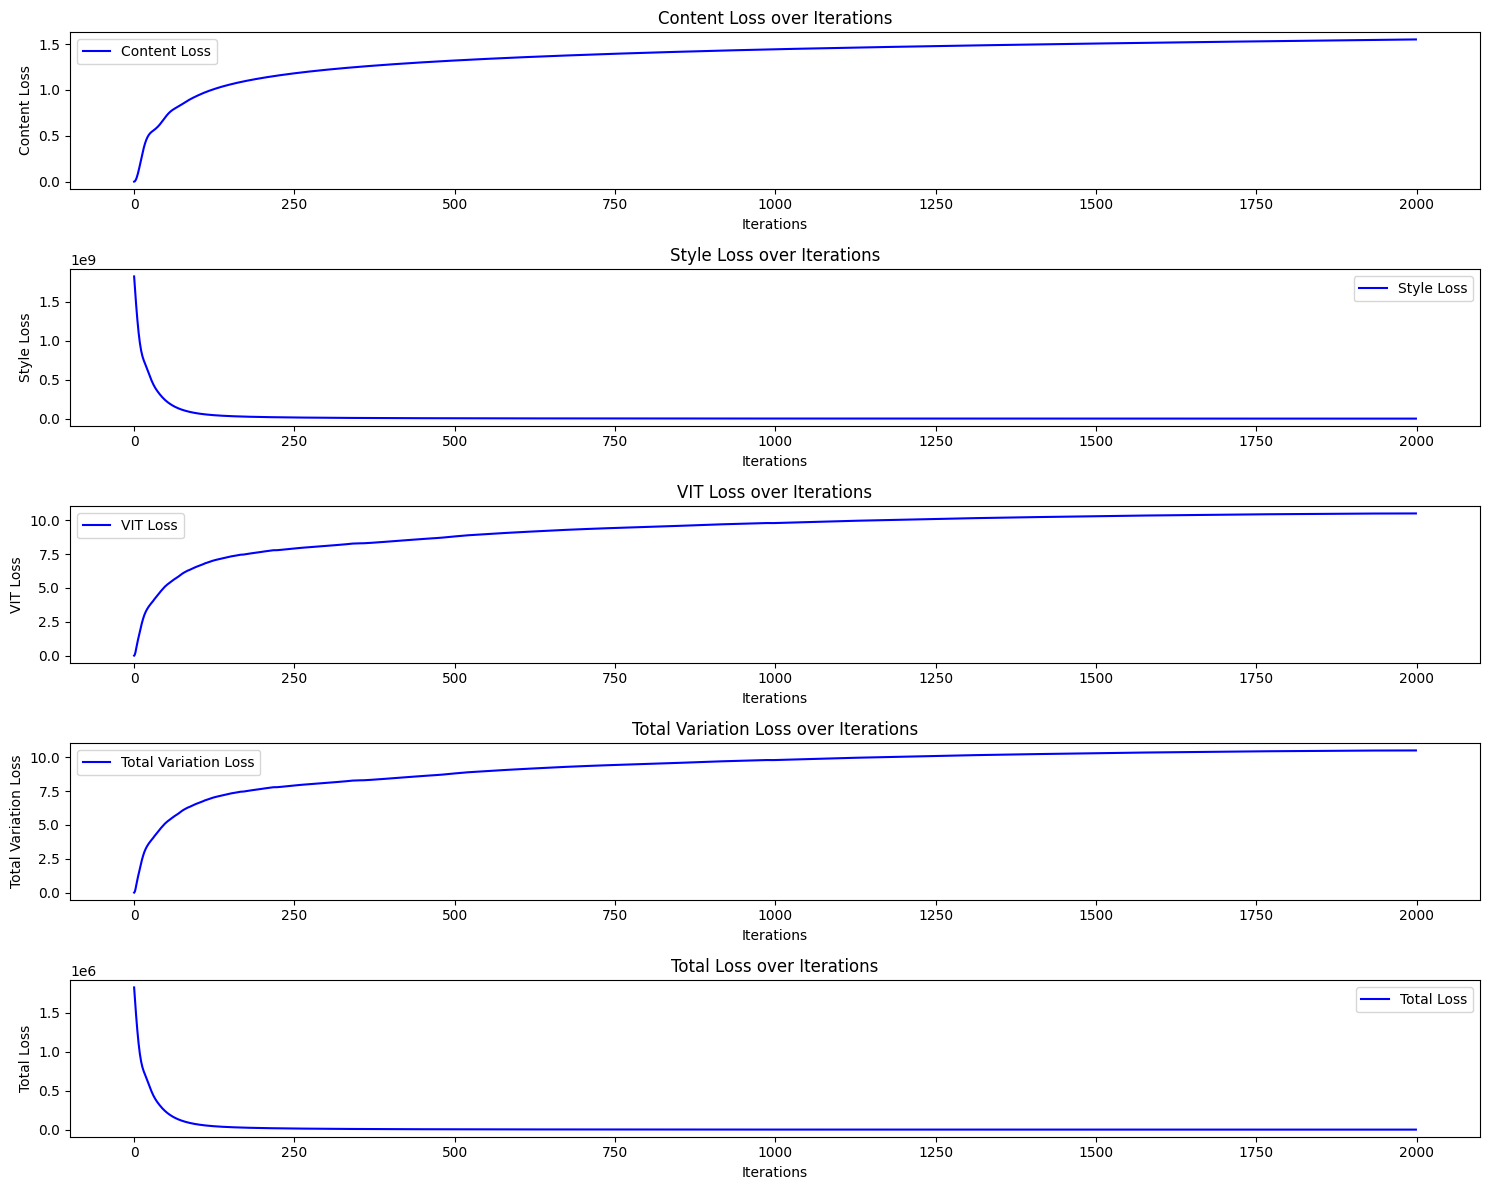

In [273]:
import matplotlib.pyplot as plt


# Plotting each loss in separate subplots
plt.figure(figsize=(15, 12))

# Plot for Content Loss
plt.subplot(5, 1, 1)
plt.plot(content_losses, label='Content Loss', color='blue')
plt.title('Content Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Content Loss')
plt.legend()

# Plot for Style Loss
plt.subplot(5, 1, 2)
plt.plot(style_losses, label='Style Loss', color='blue')
plt.title('Style Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Style Loss')
plt.legend()

# Plot for VIT Loss
plt.subplot(5, 1, 3)
plt.plot(vit_losses, label='VIT Loss', color='blue')
plt.title('VIT Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('VIT Loss')
plt.legend()

# Plot for VIT Loss
plt.subplot(5, 1, 4)
plt.plot(vit_losses, label='Total Variation Loss', color='blue')
plt.title('Total Variation Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Total Variation Loss')
plt.legend()

# Plot for Total Loss
plt.subplot(5, 1, 5)
plt.plot(total_losses, label='Total Loss', color='blue')
plt.title('Total Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.legend()


plt.tight_layout()


print(f"Final Content Fidelity Score: {final_content_fidelity.item()}")
print(f"Final Style Accuracy Score: {final_style_accuracy.item()}")
print(f"Final Overall Aesthetic Score: {final_overall_aesthetic}")
print("SSIM:", ssim_score)
print("PSNR:", psnr_score)